# Prediction of Enrichment Efficiency in the Recovery of Gold from Ore

The purpose of this work is to prepare a prototype of a ML model for predicting the efficiency of enrichment of rough and final concentrates during the recovery of gold from gold ore.  
The work will be carried out in three stages:  
1. Data preparation  
2. Exploratory analysis  
3. Train the model  


## Data Preparation

In [1]:
# Importing required libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14, 8)}, palette='Set2', font_scale=1.25)
np.random.seed(23)

In [2]:
# Set random state
RS = 23

In [3]:
# Data Loading
data_train = pd.read_csv('gold_recovery_train_new.csv')
data_test = pd.read_csv('gold_recovery_test_new.csv')
data_full = pd.read_csv('gold_recovery_full_new.csv')

### Data description
The data is stored in three files:  
- gold_recovery_train.csv — training dataset download
- gold_recovery_test.csv — test dataset download
- gold_recovery_full.csv — source dataset download  

Data is indexed with the date and time of acquisition. Parameters that are next to each other in terms of time are often similar. Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.  
The source dataset contains the training and test sets with all the features.  
We have raw data which was only downloaded from the warehouse. Before building the model, we should check the correctness of the data.

**Technological process**  
- Rougher feed — raw material  
- Rougher additions — flotation reagents: Xanthate, Sulphate, Depressant  
  - Xanthate — promoter or flotation activator  
  - Sulphate — sodium sulphide for this particular process  
  - Depressant — sodium silicate  
- Rougher process — flotation  
- Rougher tails — product residues  
- Float banks — flotation unit  
- Cleaner process — purification  
- Rougher Au — rougher gold concentrate  
- Final Au — final gold concentrate  

### Parameters of stages  
- air amount — volume of air  
- fluid levels — levels of fluid  
- feed size — feed particle size  
- feed rate — feed rate  

### Feature naming  
**Scheme:**  
[stage].[parameter_type].[parameter_name]  

**Example:**  
rougher.input.feed_ag

Possible values for [stage]:  
- rougher — flotation  
- primary_cleaner — primary purification  
- secondary_cleaner — secondary purification  
- final — final characteristics  

Possible values for [parameter_type]:  
- input — raw material parameters  
- output — product parameters  
- state — parameters characterizing the current state of the stage  
- calculation — calculated characteristics  

Let's take a look at the available data.

In [4]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [6]:
len(data_train[data_train.isna().any(axis=1)])

3132

The dataset size is 14149 rows and 87 columns. Most of the columns have missing data. A total of 3132 rows with missing data.

In [7]:
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [9]:
len(data_test[data_test.isna().any(axis=1)])

61

The dataset has 5290 rows and 53 columns. There are columns with missing data. There are 61 lines with missing data in total.

In [10]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [11]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [12]:
len(data_full[data_full.isna().any(axis=1)])

3345

The dataset has 19439 rows and 87 columns. There are columns with missing data. A total of 3345 rows with missing data.

In [13]:
data_full.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

###  Calculation MAE of the enrichment efficiency

Let's check that the enrichment efficiency is calculated correctly. Calculate it on the training sample for the feature rougher.output.recovery. Then find the MAE between our calculations and the feature value.

In [14]:
# share of gold in concentrate after flotation/refining
c_rough = data_train['rougher.output.concentrate_au']
# share of gold in raw material/concentrate before flotation/refining
f_rough = data_train['rougher.input.feed_au']
# proportion of gold in waste tailings after flotation/refining
t_rough = data_train['rougher.output.tail_au']

In [15]:
def recovery_calc(c, f, t):
    return 100 * (c * (f - t)) / (f * (c - t))

In [16]:
# We calculate the enrichment efficiency
data_train['rougher.output.recovery_calc'] = recovery_calc(c_rough, f_rough, t_rough)

In [17]:
recovery_calc = data_train['rougher.output.recovery_calc']

In [18]:
recovery_true = data_train['rougher.output.recovery']

In [19]:
# MAE calculation
rough_out_recovery_mae = mean_absolute_error(recovery_true, recovery_calc)

In [20]:
f'MAE: {rough_out_recovery_mae}'

'MAE: 1.1131451184435918e-14'

The MAE value is exceptionally small. We can safely assume that the data is calculated correctly.

### Analysis of features missing in the test sample

Let's create a list of such features.

In [21]:
data_test_missing = [col for col in data_full.columns if col not in data_test.columns]

In [22]:
data_test_missing

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [23]:
len(data_test_missing)

34

There are 34 features missing in the test sample. Looking at the list of features, we can conclude that these features contain information about the content of gold and associated elements at subsequent stages. These signs contain the calculated and output characteristics of the process that cannot be obtained or measured during the execution of the technological process.

In [24]:
data_test.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

###  Data Preprocessing

Transforming the data into a time series - set the values of the 'date' column as indexes. Thus, we will simultaneously get rid of the column with string values in features and link data from different datasets.

In [25]:
data_train = data_train.set_index('date')
data_test = data_test.set_index('date')
data_full = data_full.set_index('date')

#### Data Missings Filling in

There are a small number missings in the data, but these missings affect a large number of rows. Therefore, we will fill in the gaps according to the method for neighboring values.

In [26]:
data_test = data_test.fillna(method='ffill', axis=1)
data_test = data_test.fillna(method='bfill', axis=1)

In [27]:
data_test[data_test.isna().any(axis=1)]

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,


In [28]:
data_train = data_train.fillna(method='ffill', axis=1)
data_test = data_test.fillna(method='bfill', axis=1)

In [29]:
data_train[data_train.isna().any(axis=1)]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_calc
date,,,,,,,,,,,,,,,,,,,,,
2016-06-08 17:59:59,NaN,NaN,10.188231,29.020814,63.725335,7.387115,2.072266,16.982505,2.908215,83.915221,...,-548.815307,7.011665,-537.231749,8.031238,-550.028193,5.984399,-549.63625,18.01224,-551.325271,84.616723


## Data Analysis

### Study of the dynamics of changes in the concentration of metals

The attribute 'secondary_cleaner.output.tail' can be observed in data for each of the metals, but according to the technological scheme of the process, this parameter duplicates 'final.output.tail'. After the second cleaning stage, we get the final concentrates and tails, but the 'secondary_cleaner.output.concetrate' column is not found in our data. Apparently this is a bug in data preparation, so let's not use the 'secondary_cleaner.output.tail' columns and remove them from the data.

In [30]:
data_train = data_train.drop(['secondary_cleaner.output.tail_ag', 
                              'secondary_cleaner.output.tail_pb', 
                              'secondary_cleaner.output.tail_au'], axis=1)

Let's see how the concentration of metals Au, Ag, Pb changes at different stages of purification. To do this, we first create a list of columns in which we have the concentration of metals at various stages.

In [31]:
me_columns = []
for col in data_train.columns:
    if any(('ag' in col, 'au' in col, 'pb' in col)) and 'calculation' not in col:
        me_columns.append(col)

In [32]:
me_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_au']

Then creating a dataframe with average concentrations of metals

In [33]:
me_data = data_full[me_columns].T.reset_index()

In [34]:
# Creating an additional column in the dataframe, where the metal will be indicated
me_data['metall'] = me_data['index'].apply(lambda x: x[-2:].capitalize())
# At index column placing just the name of stage
me_data['index'] = me_data['index'].apply(lambda x: x[:-3])
# Renaming the columns
me_data.rename(columns={'index': 'stage', 0: 'values'}, inplace=True)
# Melting the data forming categorical features 'metall' и 'stage'
me_data_long = me_data.melt(id_vars=['metall', 'stage']).drop('date', axis=1)
# Adding new column with type of process
me_data_long['stage_type'] = me_data_long['stage'].apply(lambda x: x.split('.')[-1])

A helper function for specifying stage numbers and specify the stage numbers in the dataframe.

In [35]:
def stage_number(stage):
    if 'feed' in stage:
        return 0
    if 'rougher.output' in stage:
        return 1
    if 'primary_cleaner.output' in stage:
        return 2
    if 'final.output' in stage:
        return 3

In [36]:
# Applying the function to the 'stage' column
me_data_long['stage_number'] = me_data_long['stage'].apply(stage_number)

Then plot graphs of metal concentrations depending on the stage of the process.

#### Concentrate

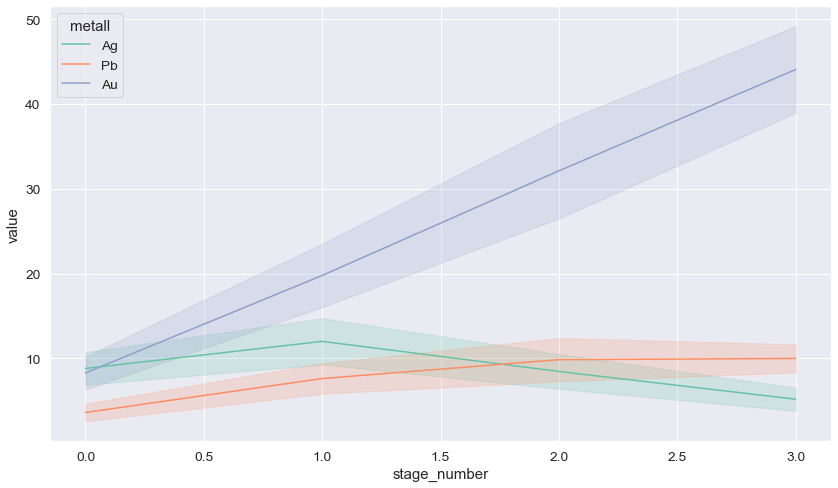

In [37]:
sns.lineplot(data=me_data_long[me_data_long['stage_type'] != 'tail'], 
             x='stage_number', 
             y='value', 
             hue='metall', 
             ci='sd');

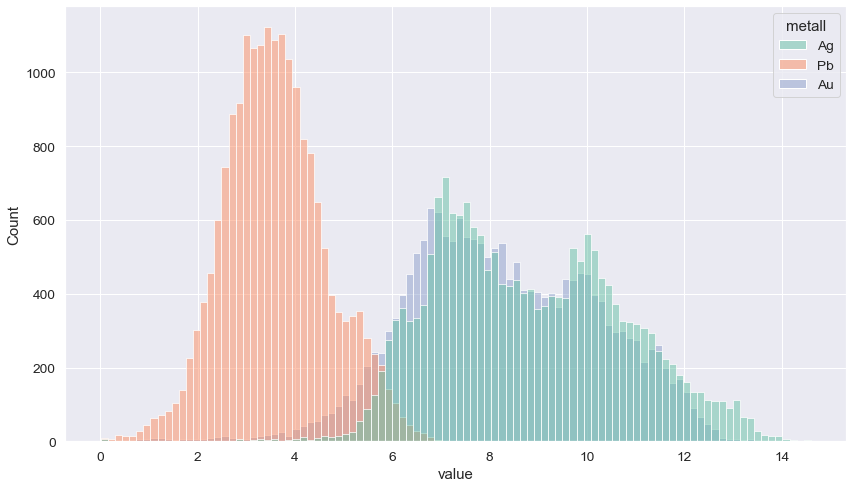

In [38]:
sns.histplot(data=me_data_long[(me_data_long['stage_type'] != 'tail') & 
                               (me_data_long['stage_number'] == 0)], 
             x='value', 
             hue='metall', 
             bins=100);

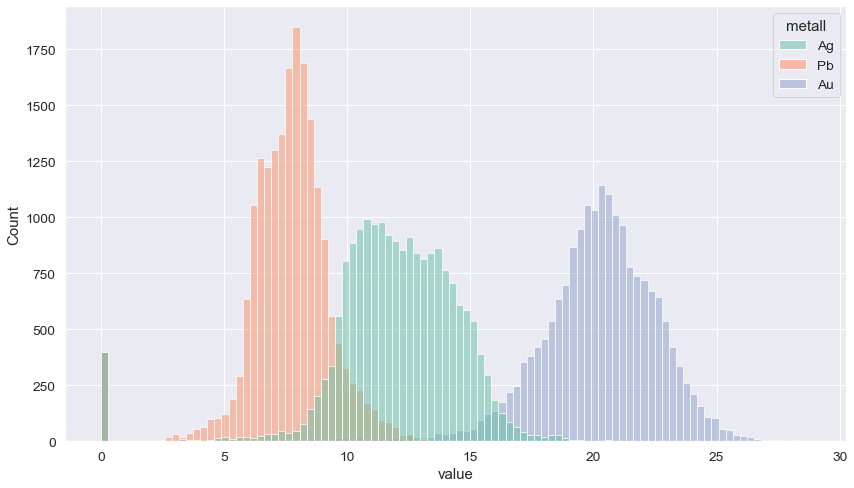

In [39]:
sns.histplot(data=me_data_long[(me_data_long['stage_type'] != 'tail') & 
                               (me_data_long['stage_number'] == 1)], 
             x='value', 
             hue='metall', 
             bins=100);

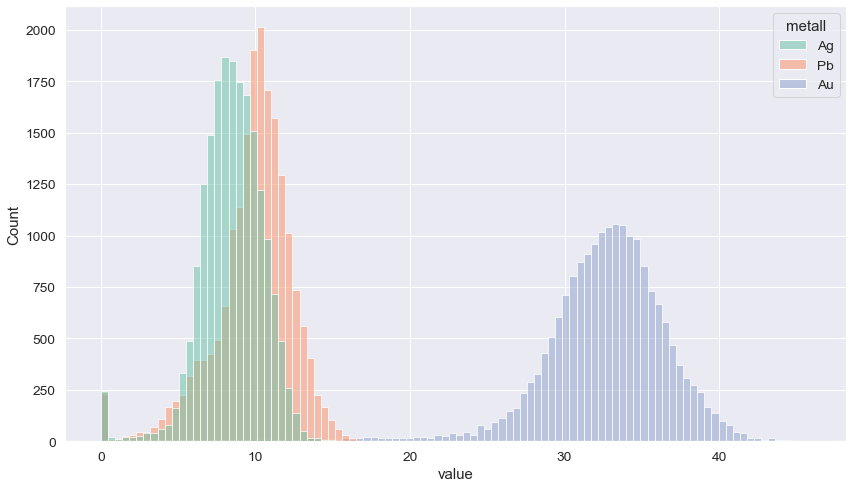

In [40]:
sns.histplot(data=me_data_long[(me_data_long['stage_type'] != 'tail') & 
                               (me_data_long['stage_number'] == 2)], 
             x='value', 
             hue='metall', 
             bins=100);

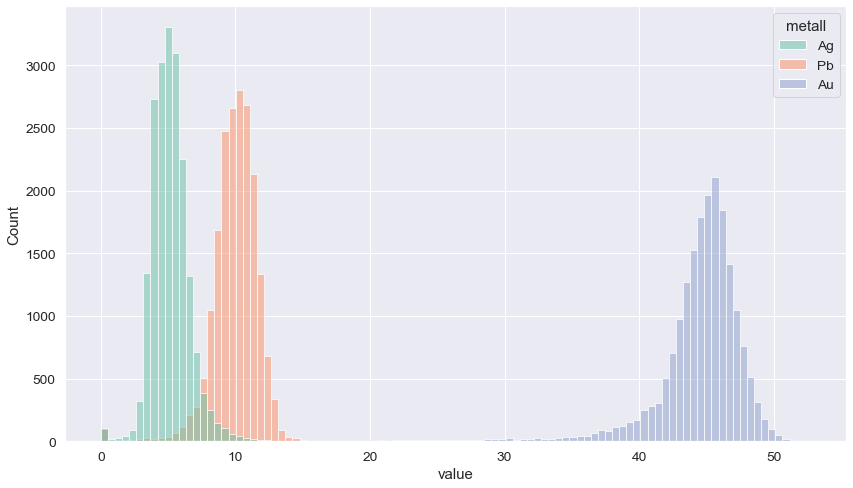

In [41]:
sns.histplot(data=me_data_long[(me_data_long['stage_type'] != 'tail') & 
                               (me_data_long['stage_number'] == 3)], 
             x='value', 
             hue='metall', 
             bins=100);

In [42]:
me_data_long[me_data_long['stage_type'] != 'tail'].pivot_table(
    index=['stage', 'metall', 'stage_number'], 
    values='value').sort_values(by='stage_number')

value
stage                              metall stage_number           
rougher.input.feed                 Ag     0              8.794927
                                   Au     0              8.266097
                                   Pb     0              3.598085
rougher.output.concentrate         Ag     1             11.994759
                                   Au     1             19.772000
                                   Pb     1              7.606272
primary_cleaner.output.concentrate Ag     2              8.442408
                                   Au     2             32.119400
                                   Pb     2              9.829530
final.output.concentrate           Ag     3              5.168470
                                   Au     3             44.076513
                                   Pb     3              9.978895

#### Waste tailings

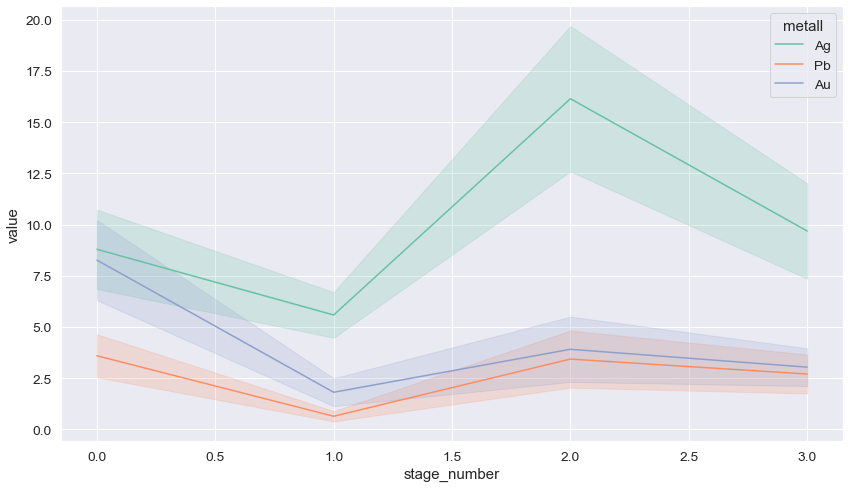

In [43]:
sns.lineplot(data=me_data_long[me_data_long['stage_type'] != 'concentrate'], 
             x='stage_number', 
             y='value', 
             hue='metall', 
             ci='sd');

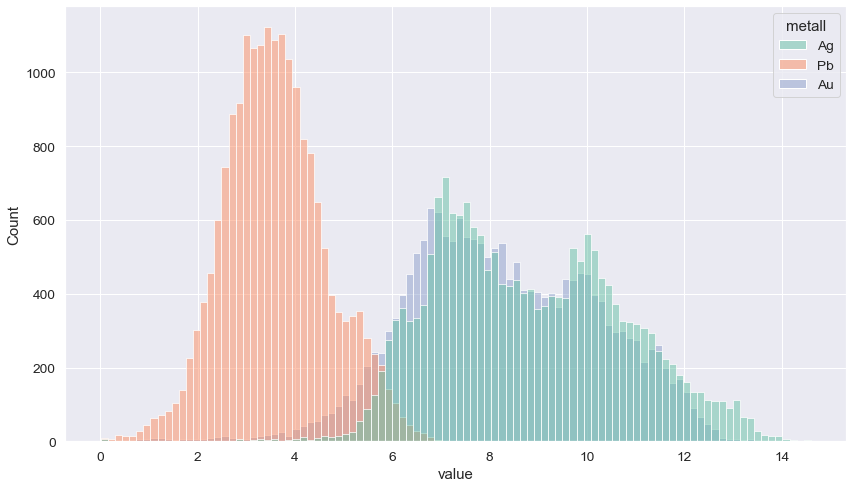

In [44]:
sns.histplot(data=me_data_long[(me_data_long['stage_type'] != 'concentrate') & 
                               (me_data_long['stage_number'] == 0)], 
             x='value', 
             hue='metall', 
             bins=100);

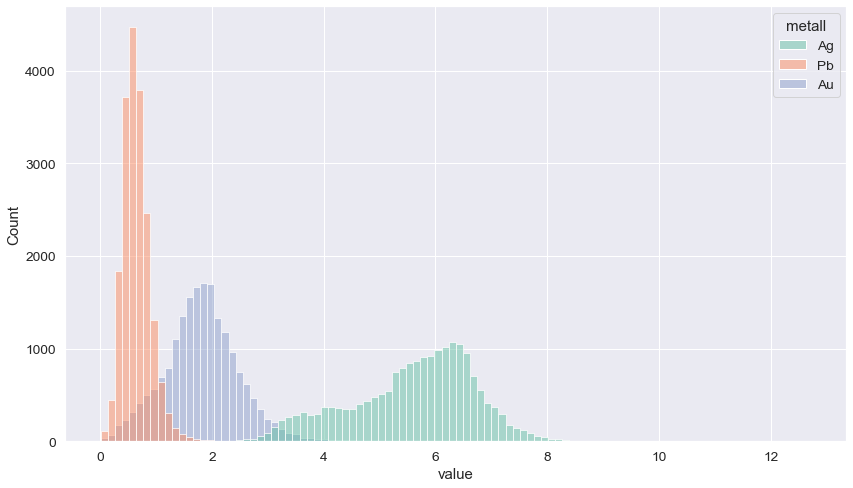

In [45]:
sns.histplot(data=me_data_long[(me_data_long['stage_type'] != 'concentrate') & 
                               (me_data_long['stage_number'] == 1)], 
             x='value', 
             hue='metall', 
             bins=100);

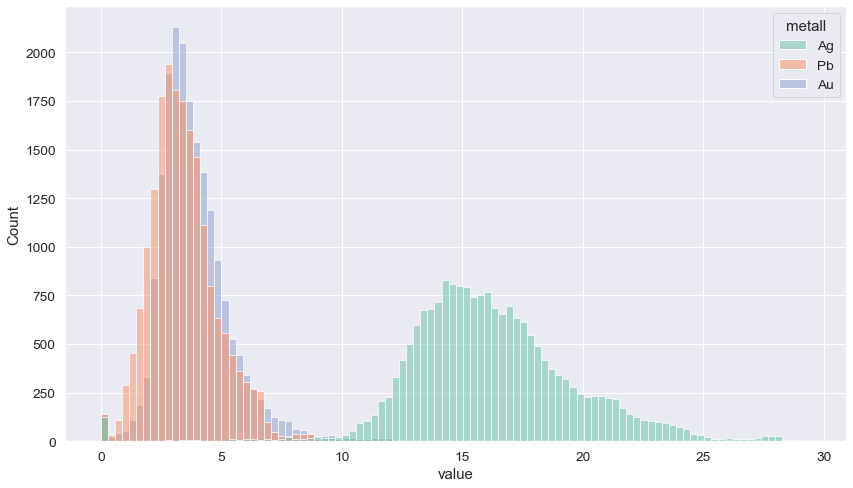

In [46]:
sns.histplot(data=me_data_long[(me_data_long['stage_type'] != 'concentrate') & 
                               (me_data_long['stage_number'] == 2)], 
             x='value', 
             hue='metall', 
             bins=100);

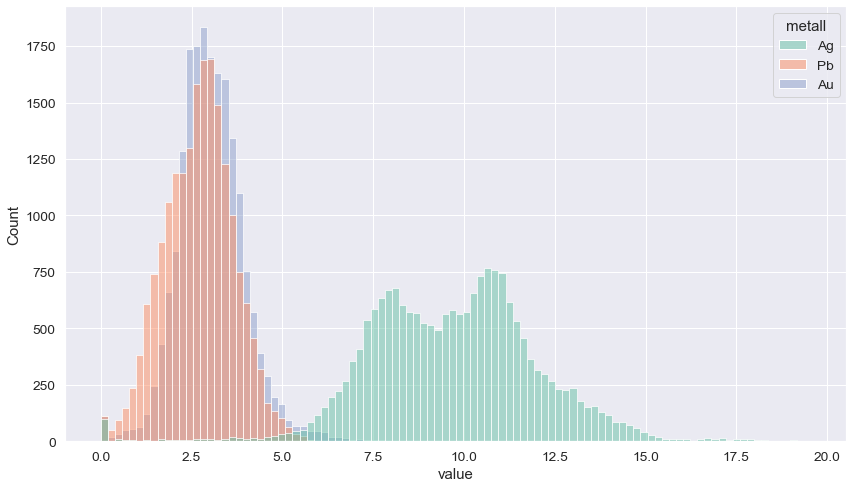

In [47]:
sns.histplot(data=me_data_long[(me_data_long['stage_type'] != 'concentrate') & 
                               (me_data_long['stage_number'] == 3)], 
             x='value', 
             hue='metall', 
             bins=100);

In [48]:
me_data_long[me_data_long['stage_type'] != 'concentrate'].pivot_table(
    index=['stage', 'metall', 'stage_number'], 
    values='value').sort_values(by='stage_number')

value
stage                       metall stage_number           
rougher.input.feed          Ag     0              8.794927
                            Au     0              8.266097
                            Pb     0              3.598085
rougher.output.tail         Ag     1              5.588982
                            Au     1              1.816391
                            Pb     1              0.645782
primary_cleaner.output.tail Ag     2             16.145826
                            Au     2              3.914179
                            Pb     2              3.435656
final.output.tail           Ag     3              9.688589
                            Au     3              3.042467
                            Pb     3              2.705795

#### Conclusion

Gold concentration target in concentrate increases linearly with each successive stage. The concentrations of other metals remain approximately at the same levels.  
In tailings, the concentration of gold and lead has a downward trend. The silver concentration ranges from 5.6 to 16%.

### Comparison of the distribution of granules on the test and training samples

To compare, let's create a dataframe and add the values ​​of the granule size of both samples to it.

In [49]:
# Creating new sets for train and test splits
input_feed_test = pd.DataFrame(data_test['rougher.input.feed_size'])
input_feed_train = pd.DataFrame(data_train['rougher.input.feed_size'])

In [50]:
# Adding 'test' and 'train' labels to 'set' column
input_feed_test['set'] = 'test'
input_feed_train['set'] = 'train'

In [51]:
# Concatenating two dataframes
feed_size = pd.concat((input_feed_test, input_feed_train), join='outer', axis=0)

In [52]:
# Melting dataframe forming set column (set type)
feed_size = feed_size.melt(id_vars='set').drop('variable', axis=1).rename(columns={'value': 'feed_size'})

Let's plot box plots and histograms of distributions.

In [53]:
def double_dist_plot(data, column1, column2, title, limit=None):
    fig, (ax_box, ax_hist) = plt.subplots(2, 
                                          sharex=True, 
                                          gridspec_kw={"height_ratios": (.25, .75)})
    if limit is not None:
        plt.xlim(limit)
    sns.boxplot(data=data, 
                x=column1, 
                y=column2, 
                ax=ax_box)
    sns.histplot(data=data, 
                 x=column1, 
                 hue=column2, 
                 ax=ax_hist,
                 bins=100, 
                 element="bars", 
                 stat="density", 
                 common_norm=False)
    ax_box.set(xlabel='')

    fig.suptitle(title)

    plt.show();

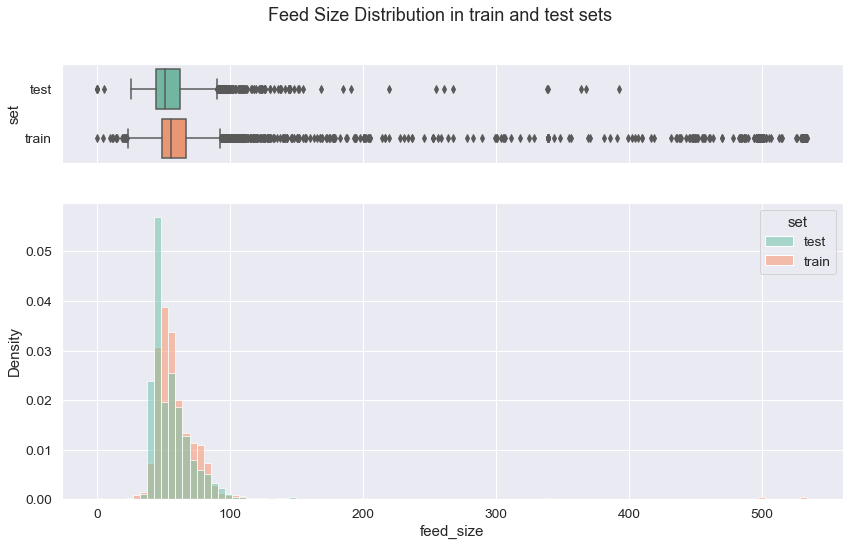

In [54]:
double_dist_plot(feed_size, 
                 'feed_size', 
                 'set', 
                 'Feed Size Distribution in train and test sets')

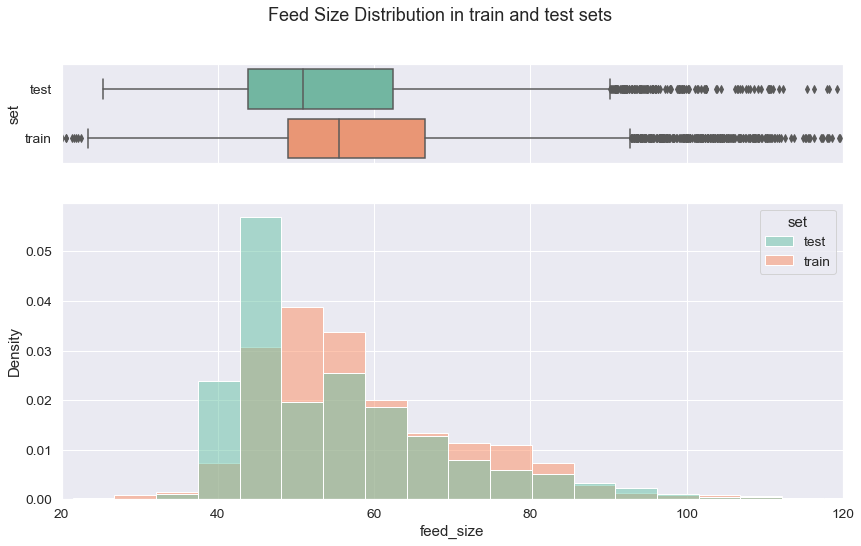

In [55]:
double_dist_plot(feed_size, 
                 'feed_size', 
                 'set', 
                 'Feed Size Distribution in train and test sets',
                 limit=(20, 120))

#### Conclusion

According to the graphs, we can state that in general the distributions are similar. Therefore, we can build a machine learning model and check it on a test set.

### Study of the total concentration of substances at various stages

Let's calculate the total concentrations of substances at different stages.

In [56]:
data_full['rougher.input.calculation.feed_sum'] = (data_full['rougher.input.feed_ag'] + 
                                     data_full['rougher.input.feed_pb'] + 
                                     data_full['rougher.input.feed_sol'] + 
                                     data_full['rougher.input.feed_au'])

In [57]:
data_full['rougher.output.calculation.concentrate_sum'] = (data_full['rougher.output.concentrate_ag'] +
                                                           data_full['rougher.output.concentrate_pb'] + 
                                                           data_full['rougher.output.concentrate_sol'] + 
                                                           data_full['rougher.output.concentrate_au'])

In [58]:
data_full['primary_cleaner.output.calculation.concentrate_sum'] = (data_full['primary_cleaner.output.concentrate_ag'] + 
                                                                   data_full['primary_cleaner.output.concentrate_pb'] + 
                                                                   data_full['primary_cleaner.output.concentrate_sol'] + 
                                                                   data_full['primary_cleaner.output.concentrate_au'])

In [59]:
data_full['final.output.calculation.concentrate_sum'] = (data_full['final.output.concentrate_ag'] + 
                                                         data_full['final.output.concentrate_pb'] + 
                                                         data_full['final.output.concentrate_sol'] + 
                                                         data_full['final.output.concentrate_au'])

Separating this information into different dataframes and then assemble a single dataframe from them.

In [60]:
data_sum_0 = pd.DataFrame(data_full['rougher.input.calculation.feed_sum']).reset_index(
    drop=True).rename(columns={'rougher.input.calculation.feed_sum':'value'})

data_sum_1 = pd.DataFrame(data_full['rougher.output.calculation.concentrate_sum']).reset_index(
    drop=True).rename(columns={'rougher.output.calculation.concentrate_sum':'value'})

data_sum_2 = pd.DataFrame(data_full['primary_cleaner.output.calculation.concentrate_sum']).reset_index(
    drop=True).rename(columns={'primary_cleaner.output.calculation.concentrate_sum':'value'})

data_sum_3 = pd.DataFrame(data_full['final.output.calculation.concentrate_sum']).reset_index(
    drop=True).rename(columns={'final.output.calculation.concentrate_sum':'value'})

In [61]:
data_sum_0['stage'] = 'rougher.input'
data_sum_1['stage'] = 'rougher.output'
data_sum_2['stage'] = 'primary_cleaner.output'
data_sum_3['stage'] = 'final.output'

In [62]:
data_sum_stages = pd.concat([data_sum_0, 
                             data_sum_1, 
                             data_sum_2, 
                             data_sum_3], axis=0).reset_index(drop=True)

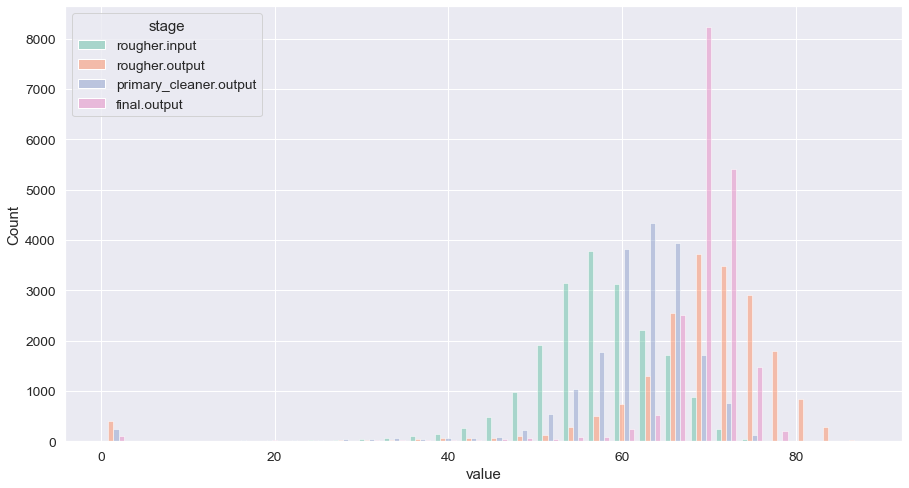

In [63]:
# Distribution of cpmcentraions by process stages
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data=data_sum_stages, x='value', hue='stage', bins=30,
             alpha=0.5, shrink=0.8, multiple='dodge', ax=ax);

There are anomaly values can be noticed ad histograms - zero total concentrations. In these cases, there could be errors in determining the concentrations of substances. Or just an accidental waste ore. Zero values of concentrations should be removed from the dataset.

In [64]:
train_null = set()

In [65]:
for col in ['rougher.input.calculation.feed_sum', 
            'rougher.output.calculation.concentrate_sum', 
            'primary_cleaner.output.calculation.concentrate_sum', 
            'final.output.calculation.concentrate_sum']:
    train_null = train_null.union(set(data_full[data_full[col]==0].index))

In [66]:
data_train = data_train.loc[~data_train.index.isin(train_null)]

In [67]:
data_train.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

In [68]:
data_train.shape

(13725, 84)

In [69]:
data_test.shape

(5290, 52)

#### Conclusion

The analysis revealed anomalies - data with zero values of the total concentrations of substances. Probably there were errors in the measurements. Anomalous data were removed from the training set.

## ML Models training

### Preparation for training

#### Features and Target Extraction

Creating a dataset for training models. To do this, we take a training sample and leave only those features that are in the test sample.

In [70]:
X_train = data_train[data_test.columns]

In [71]:
y_train = data_train[['rougher.output.recovery', 
                      'final.output.recovery']].reset_index(drop=True)

Test set

In [72]:
X_test = data_test.copy()

In [73]:
y_test = data_full.loc[X_test.index, ['rougher.output.recovery', 
                                      'final.output.recovery']].reset_index(drop=True)

#### final quality metric function sMAPE

In [74]:
def smape(target, predictions):
    target = np.array(target)
    predictions = np.array(predictions)
    rougher = (100 * ((abs(target[:, 0] - predictions[:, 0])) / ((abs(target[:, 0]) + abs(predictions[:, 0]))/2)).mean())
    final = (100 * ((abs(target[:, 1] - predictions[:, 1])) / ((abs(target[:, 1]) + abs(predictions[:, 1]))/2)).mean())
    return 0.25 * rougher + 0.75 * final

Transforming the function to use it in cross-validation.

In [75]:
smape_scorer = make_scorer(smape, greater_is_better=False)

### Models Training

In our case, we have a task to predict two targets, so we will use a multioutput regressor.

####  Hyperparameters Tuning

In [76]:
def hp_tuning(estimator, params, features, target):
    """
    Function for selecting hyperparameters and training models.
    Taking in estimator, iterating parameters, features, target
    Returning back best estimator and best score
    """
    pipe = Pipeline([('scl', StandardScaler()),
                     ('reg', MultiOutputRegressor(estimator))])
    rand_search = (RandomizedSearchCV(estimator=pipe,
                                      param_distributions=params,
                                      cv=5,
                                      scoring = smape_scorer,
                                      n_iter=20,
                                      random_state=RS,
                                      n_jobs = -1))
    rs = rand_search.fit(features, target)
    return rs.best_estimator_, -rs.best_score_

#### Ridge Regression Model

In [77]:
params_ridge = {'reg__estimator__alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000)}

In [78]:
model_ridge, score_ridge = hp_tuning(Ridge(random_state=RS), params_ridge, X_train, y_train)

In [79]:
score_ridge

9.122520416129522

#### Linear Support Vector Regression Model

In [80]:
params_svr = {'reg__estimator__C': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000)}

In [81]:
model_svr, score_svr = hp_tuning(LinearSVR(random_state=RS), 
                                 params_svr, 
                                 X_train, 
                                 y_train)

In [82]:
score_svr

9.80541339212775

#### Random Forest Model

In [83]:
params_rf = {'reg__estimator__max_depth': range(1, 11, 2),
             'reg__estimator__n_estimators': range(50, 351, 50),
             'reg__estimator__min_samples_leaf': range(1, 51, 5)}

In [84]:
model_rf, score_rf = hp_tuning(RandomForestRegressor(random_state=RS), 
                               params_rf, 
                               X_train, 
                               y_train)

In [85]:
score_rf

8.437895691449276

####  Extra Trees Model

In [86]:
params_et = {'reg__estimator__max_depth': range(1, 11, 2),
             'reg__estimator__n_estimators': range(50, 351, 50),
             'reg__estimator__min_samples_leaf': range(1, 51, 5)}

In [87]:
model_et, score_et = hp_tuning(ExtraTreesRegressor(random_state=RS), 
                               params_et, 
                               X_train, 
                               y_train)

In [88]:
score_et

8.402765863521639

####  Gradient Boosting

In [89]:
params_gb = {'reg__estimator__learning_rate': np.arange(0.001, 0.1, 0.005),
             'reg__estimator__min_samples_leaf': range(1, 51, 5),
             'reg__estimator__n_estimators': range(50, 351, 50)}

In [90]:
model_gb, score_gb = hp_tuning(GradientBoostingRegressor(random_state=RS), 
                               params_gb, 
                               X_train, 
                               y_train)

In [91]:
model_gb[-1].estimators_[0]

GradientBoostingRegressor(learning_rate=0.011, min_samples_leaf=16,
                          n_estimators=200, random_state=23)

In [92]:
score_gb

8.241520589998611

#### Conclusion

In [93]:
f'The gradient boosting model showed the best result for the sMAPE metric: {score_gb}%'

'The gradient boosting model showed the best result for the sMAPE metric: 8.241520589998611%'

### Model Test

In [94]:
def test_model(model, features, target):
    predictions = model.predict(features)
    return smape(target, predictions)

#### Random Forest Model

In [95]:
test_model(model_et, X_test, y_test)

8.76924310556463

#### Gradient Boosting Model

In [96]:
test_model(model_gb, X_test, y_test)

8.657730292179625

#### Constant Model

In order to check the model for adequacy, as well as for an additional comparison benchmark, we calculate the predictions of the constant model.

In [97]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)

DummyRegressor()

In [98]:
test_model(dummy, X_test, y_test)

9.831066377059802

The model passed the test. Also, the result of both models turned out to be better than the result of the constant model.

###  Conclusion

During the study, five different machine learning models were trained: linear regression, support vector machines, random forest, super-random forest, and gradient boosting. The best result was shown by the gradient boosting model with an average result on the training set and on the test set.

##  Summary

1. Data preparation  
- The available data have been examined. There are three datasets - training, test and full. Missing values were found in all datasets.  
- MAE efficiency of the enrichment of the crude concentrate was calculated. The obtained value was compared with the one in the table. The difference in data is not any significant.
- We analysed the features that were absent in the test sample. There are 34 features missing in the test sample. These features contain information about the content of gold and associated elements in subsequent stages.
- Missing values were filled in using the nearest values.

2. Data analysis.
- The dynamics of changes in the concentration of metals was studied. In concentrate, the gold concentration target increases linearly with each successive stage. The concentrations of other metals remain approximately at the same levels. In tailings, the concentration of gold and lead has a downward trend. The silver concentration ranges from 5.6 to 16%.
- We compared the distribution of granules in test and training samples. It was concluded that the samples can be considered similar.
- Then total concentration of substances was analysed. There were some anomalies identified - data with zero values of the total concentrations of substances. Probably there were errors in the measurements. The anomalous data has been removed.

3. Models training.  
- During the study, five different ML models were trained: linear regression, support vector regression, random forest, extra-trees and gradient boosting. The best result was shown by the gradient boosting model with an average result on the training set: 7.7% and 6.7% on the test set.